# April 7th, 2021

**Motivation**: Overlapping communities: exploring LFR benchmark and SVINET algorithm. </br>

In [255]:
# HIDE CODE


# generic imports
import re
import os
import sys
import random
import itertools
import collections
import numpy as np
import pandas as pd
import networkx as nx
import nibabel as nib
from pprint import pprint
from scipy import signal
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from os.path import join as pjoin
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import patches
from matplotlib import cm
import seaborn as sns
sns.set_style('white')


# Filter warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# nx imports
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.classes.function import density

# Louvain etc
import community as community_louvain
from cdlib import algorithms

# network measures
from networkx.algorithms.cluster import transitivity, average_clustering
from networkx.algorithms.assortativity import degree_pearson_correlation_coefficient
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency
from networkx.algorithms.approximation.clique import large_clique_size
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
from networkx.algorithms.smallworld import sigma, omega

# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from utils.plotting import *
from utils.processing import *
from model.configuration import ProcessConfig

# Workspace dirs
lfr_ws = 'Documents/workspaces/lfr/weighted_overlapping/networks'
lfr_ws = pjoin(os.environ['HOME'], lfr_ws)
svinet_dir = './svinet_results'

# svinet...


# fix random stete
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
rng = np.random.RandomState(RANDOM_STATE)

## A highly modular network with no overlap

Code to generate this network:

```bash
./benchmark -N 1000 -k 100 -maxk 300 -mut 0.1 -muw 0.1 -t1 3 -t2 1.7 -minc 600 -on 0 -om 0

```

In [256]:
network_name = 'no_overlap'
lfr = load_lfr(load_dir=pjoin(lfr_ws, network_name), random_state=rng)

Num true communities:	6
Num overlapping nodes:	0



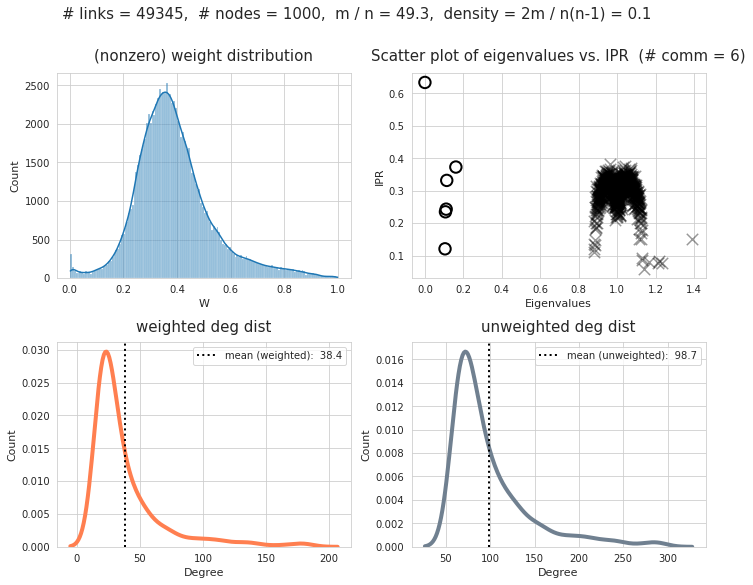

In [257]:
quick_viz(g=lfr['g'], a=lfr['a'], num_comm=len(lfr['community']))

### Louvain

The communities in this network are highly disjoint and Louvain is expected to recover ground truth.

In [258]:
partition_pred = community_louvain.best_partition(lfr['g'], resolution=1.0, random_state=RANDOM_STATE)
membership_pred = convert('partition', 'membership', partition=partition_pred, random_state=rng)
community_pred = convert('partition', 'community', partition=partition_pred, random_state=rng)

#### Plot results

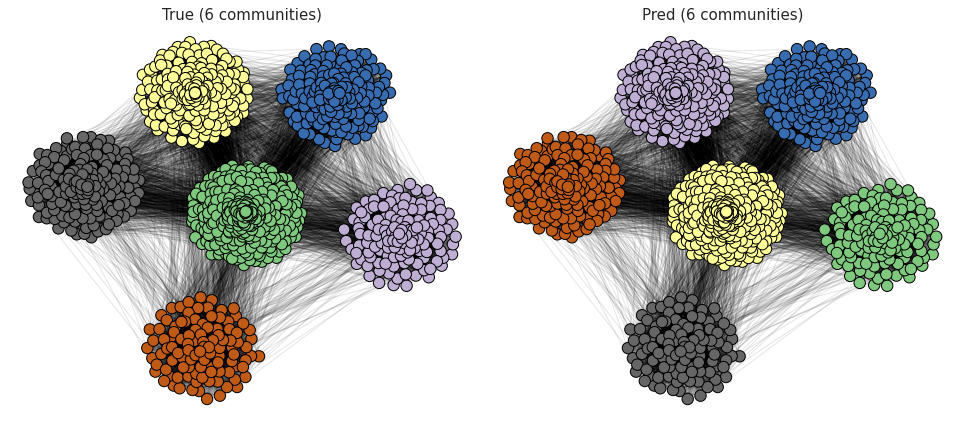

In [259]:
plot_graph(lfr['g'], partition_pred=partition_pred, partition_true=lfr['partition'])

Louvain learns the true community structure

#### Quantitative comparison 

Compute normalized_mutual_info between ground truth as returned by the benchmark code, and the partition learned by Louvain algorithm.

In [260]:
nmi, overlapping_nmi, ami, v_measure = compare_partitions(
    partition_true=lfr['partition'],
    partition_pred=partition_pred,
    community_true=lfr['community'],
    community_pred=community_pred,
)

+-----+-----------------+------------------+-----------+-----+-----------+
| NMI | overlapping-NMI | overlapping-NMI2 | Omeda-idx | AMI | v-measure |
+-----+-----------------+------------------+-----------+-----+-----------+
| 1.0 |       1.0       |       1.02       |    0.18   | 1.0 |    1.0    |
+-----+-----------------+------------------+-----------+-----+-----------+


#### Plot adjacency matrix

Here I will group nodes together using i) ground truth, and ii) Louvain community labels.  Here we also see that the gruond truth labels must be wrong.

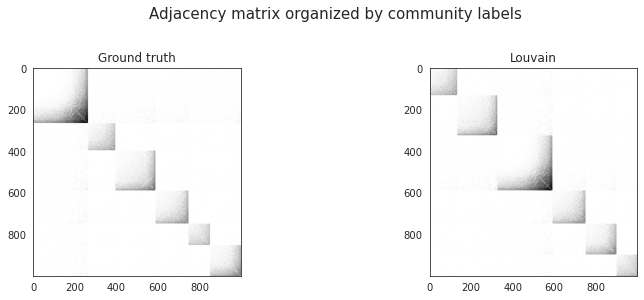

In [261]:
sns.set_style('white')
plt.figure(figsize=(12, 4))

plt.subplot(121)
idxs = np.concatenate(list(lfr['community'].values()))
plt.imshow(lfr['a'][idxs][:, idxs], cmap='Greys', interpolation='antialiased')
plt.title('Ground truth')

plt.subplot(122)
idxs = np.concatenate(list(community_pred.values()))
plt.imshow(lfr['a'][idxs][:, idxs], cmap='Greys', interpolation='antialiased')
plt.title('Louvain')

plt.suptitle('Adjacency matrix organized by community labels', fontsize=15, y=1.03)
plt.tight_layout()
plt.show()

### SVINET

In [262]:
network_name

'no_overlap'

In [263]:
save_edgelist(lfr['g'], name=network_name, save_dir=svinet_dir)

### Run algorithm

In [264]:
!cd svinet_results/; svinet -file no_overlap.txt -n 1000 -k 6 -link-sampling -seed 42

+ Output directory: n1000-k6-mmsb-seed42-linksampling
+ Writing log to n1000-k6-mmsb-seed42-linksampling/infer.log
+ Reading network from no_overlap.txt
+ 40000 entries
+ Done reading network
iteration 24: processing 49000 links

In [265]:
!cd svinet_results/; ls

003.txt     n1000-k6-mmsb-seed42-linksampling  no_overlap.txt
large.txt   n100-k3-mmsb-seed42-linksampling   overlap.txt
medium.txt  n5000-k9-mmsb-seed42-linksampling


In [266]:
results_dir = pjoin(svinet_dir, 'n1000-k6-mmsb-seed42-linksampling')
svinet = load_svinet(results_dir=results_dir)

In [267]:
nmi, overlapping_nmi, ami, v_measure = compare_partitions(
    partition_true=lfr['partition'],
    partition_pred=svinet['partition'],
    community_true=lfr['community'],
    community_pred=svinet['community'],
)

+-----+-----------------+------------------+-----------+-----+-----------+
| NMI | overlapping-NMI | overlapping-NMI2 | Omeda-idx | AMI | v-measure |
+-----+-----------------+------------------+-----------+-----+-----------+
| 0.9 |       0.26      |       0.61       |    0.18   | 0.9 |    0.9    |
+-----+-----------------+------------------+-----------+-----+-----------+


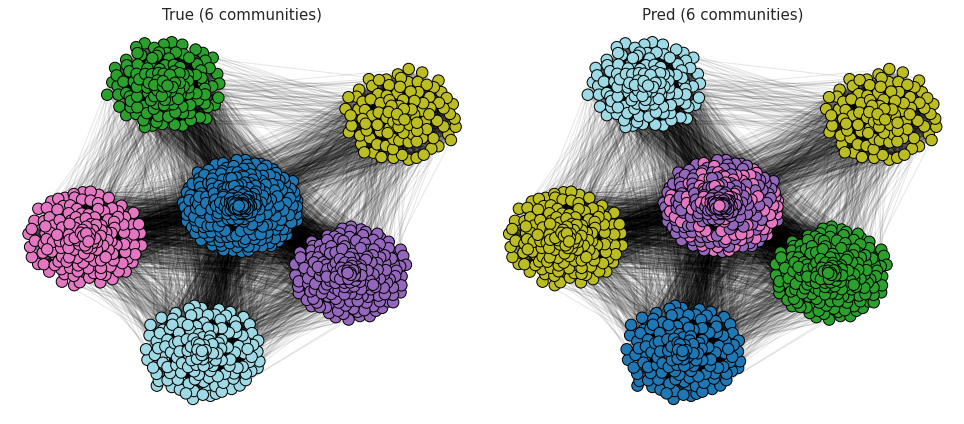

In [268]:
plot_graph(lfr['g'], partition_pred=svinet['partition'], partition_true=lfr['partition'], cmap='tab20')

### Viz memberships

In [269]:
n_nodes = lfr['g'].order()
n_comm_true = len(lfr['community'])

# true membership probabilities
pi_true = np.zeros((n_comm_true, n_nodes))
for n, mem in lfr['membership'].items():
    for comm_idx in mem:
        pi_true[comm_idx, n] = 1

pi_true /= pi_true.sum(0, keepdims=True)

# pred membership probabilities
pi_pred = np.concatenate([np.reshape(x, (1, -1)) for x in svinet['membership'].values()]).T

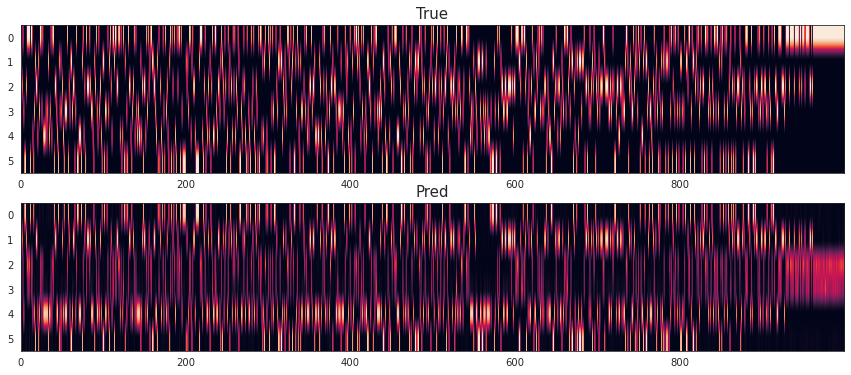

In [270]:
sns.set_style('white')
plt.figure(figsize=(24, 6))

plt.subplot(211)
plt.imshow(pi_true, aspect=30)
plt.title('True', fontsize=15)

plt.subplot(212)
plt.imshow(pi_pred, aspect=30)
plt.title('Pred', fontsize=15)

plt.show()

In [271]:
from sklearn.metrics.pairwise import cosine_similarity

In [272]:
cos_sim = cosine_similarity(pi_true, pi_pred)
print(np.round(cos_sim, decimals=1), '\n')

thres = 0.6
similarity = dict()
for true_idx in range(n_comm_true):
    sim_vec = np.where(cos_sim[true_idx] >= thres)[0]
    sim_vec = [x for _, x in sorted(zip(cos_sim[true_idx][sim_vec], sim_vec), reverse=True)]
    similarity[true_idx] = list(sim_vec)
print(similarity)

mapping = {i: sim[0] for i, sim in similarity.items()}
pi_pred = pi_pred[list(mapping.values())]

cos_sim = cosine_similarity(pi_true, pi_pred)

[[0.  0.  1.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  1. ]
 [0.  1.  0.  0.1 0.  0. ]
 [0.  0.  0.  0.1 0.8 0. ]
 [0.  0.  0.  0.  0.6 0. ]
 [1.  0.  0.  0.  0.  0. ]] 

{0: [2, 3], 1: [5], 2: [1], 3: [4], 4: [4], 5: [0]}


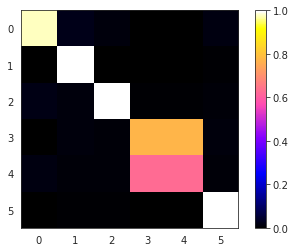

In [273]:
plt.imshow(cos_sim, vmin=0, vmax=1, cmap='gnuplot2')
plt.colorbar()

In [274]:
np.round(cos_sim, decimals=1)

array([[1. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.8, 0.8, 0. ],
       [0. , 0. , 0. , 0.6, 0.6, 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. ]])

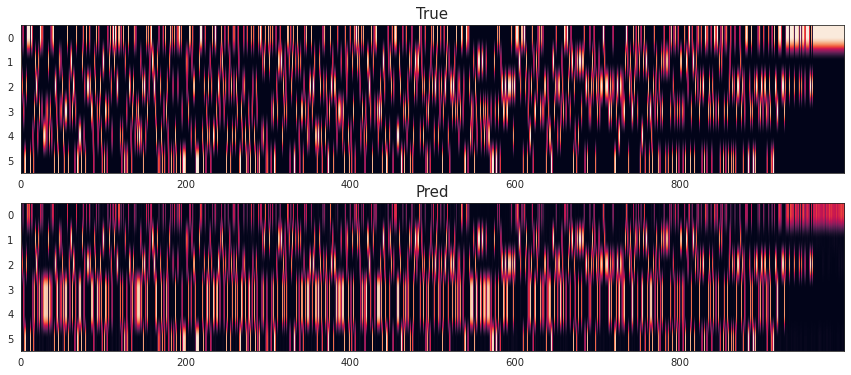

In [275]:
plt.figure(figsize=(24, 6))

plt.subplot(211)
plt.imshow(pi_true, aspect=30)
plt.title('True', fontsize=15)

plt.subplot(212)
plt.imshow(pi_pred, aspect=30)
plt.title('Pred', fontsize=15)

plt.show()

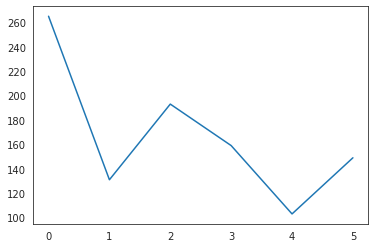

In [276]:
plt.plot(pi_true.sum(-1))

In [277]:
df = pd.DataFrame()

for i in range(len(pi_true)):
    data_dict = {
        'lbl': ['true'] * n_nodes,
        'cluster': [i] * n_nodes,
        'node': range(n_nodes),
        'p': pi_true[i],
    }
    df = pd.concat([df, pd.DataFrame.from_dict(data_dict)])

for i in range(len(pi_pred)):
    data_dict = {
        'lbl': ['pred'] * n_nodes,
        'cluster': [i] * n_nodes,
        'node': range(n_nodes),
        'p': pi_pred[i],
    }
    df = pd.concat([df, pd.DataFrame.from_dict(data_dict)])
    
df.reset_index(drop=True, inplace=True)

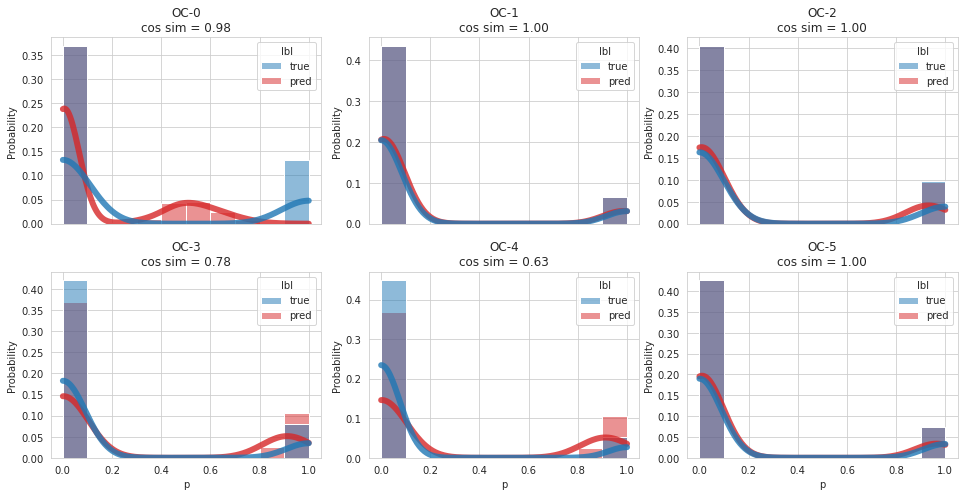

In [278]:
sns.set_style('whitegrid')
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 7), sharex='all')

for idx in range(n_comm_true):
    i, j = idx//ncols, idx%ncols
    selected_df = df.loc[df.cluster == idx]
    sns.histplot(
        data=selected_df,
        x='p',
        hue='lbl',
        stat='probability',
        kde=True,
        alpha=0.5,
        bins=np.linspace(0, 1, 11),
        palette={'true': 'C0', 'pred': 'C3'},
        line_kws={'lw': 6, 'alpha': 0.8},
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC-{:d}\ncos sim = {:.2f}'.format(idx, cos_sim[idx, idx]))
    
fig.tight_layout()
plt.show()

#### Entropy analysis

In [279]:
from scipy import special as sp_special

In [280]:
ent_true = sp_special.entr(pi_true).sum(0) / np.log(len(pi_true))
ent_pred = sp_special.entr(pi_pred).sum(0) / np.log(len(pi_pred))

/home/hadi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


(0.0, 1.01)

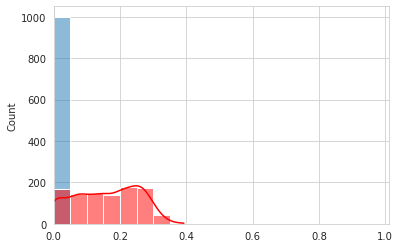

In [285]:
sns.histplot(ent_true, kde=True, bins=np.linspace(0, 1, 21))
sns.histplot(ent_pred, kde=True, bins=np.linspace(0, 1, 21), color='r')
plt.xlim(0, 1.01)

In [286]:
collections.Counter(np.round(ent_true, decimals=3))

Counter({0.0: 1000})

In [287]:
(ent_pred>0.7).sum()

0

In [288]:
(ent_true<0.7).sum()

1000

## Medium (no overlap)

Code to generate this network:

```bash
./benchmark -N 100 -k 50 -maxk 70 -mut 0.1 -muw 0.1 -t1 3.5 -t2 1.9 -minc 50 -on 0 -om 0
```

In [289]:
network_name = 'medium'
lfr = load_lfr(load_dir=pjoin(lfr_ws, network_name), random_state=rng)

Num true communities:	3
Num overlapping nodes:	0



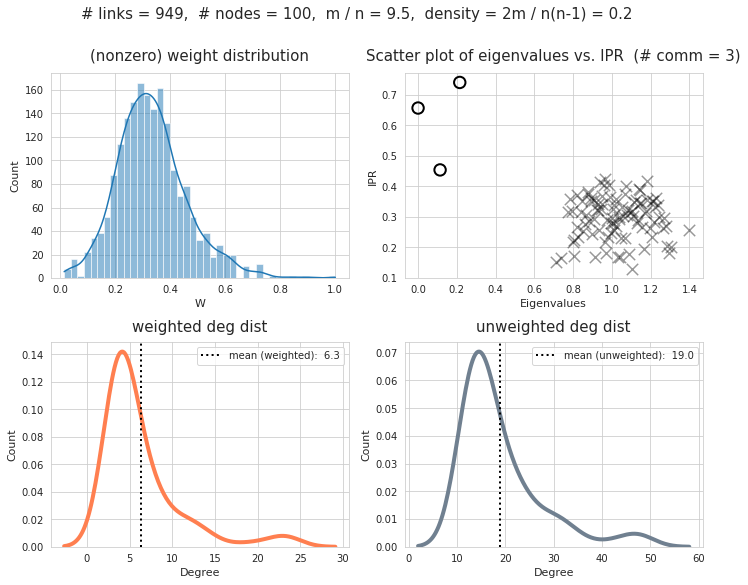

In [290]:
quick_viz(g=lfr['g'], a=lfr['a'], num_comm=len(lfr['community']))

### Louvain

The communities in this network are highly disjoint and Louvain is expected to recover ground truth.

In [291]:
partition_pred = community_louvain.best_partition(lfr['g'], resolution=1.0, random_state=RANDOM_STATE)
membership_pred = convert('partition', 'membership', partition=partition_pred, random_state=rng)
community_pred = convert('partition', 'community', partition=partition_pred, random_state=rng)

#### Plot results

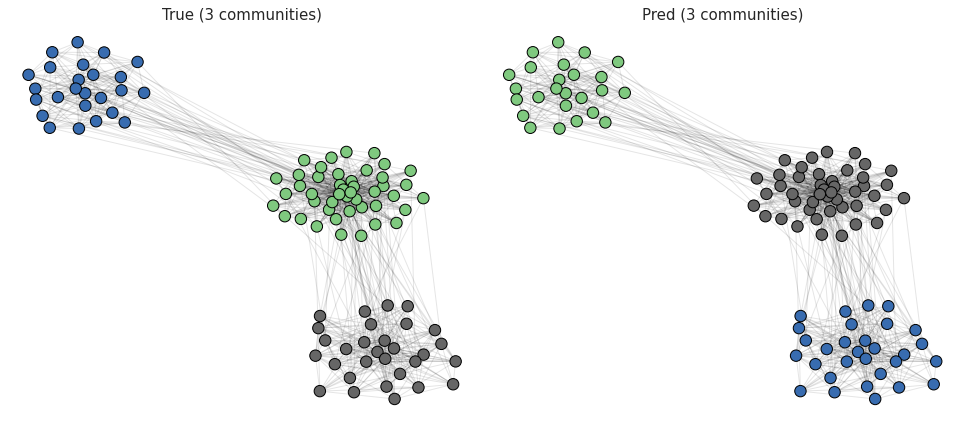

In [292]:
plot_graph(lfr['g'], partition_pred=partition_pred, partition_true=lfr['partition'])

Louvain learns the true community structure

#### Quantitative comparison 

Compute normalized_mutual_info between ground truth as returned by the benchmark code, and the partition learned by Louvain algorithm.

In [293]:
nmi, overlapping_nmi, ami, v_measure = compare_partitions(
    partition_true=lfr['partition'],
    partition_pred=partition_pred,
    community_true=lfr['community'],
    community_pred=community_pred,
)

+-----+-----------------+------------------+-----------+-----+-----------+
| NMI | overlapping-NMI | overlapping-NMI2 | Omeda-idx | AMI | v-measure |
+-----+-----------------+------------------+-----------+-----+-----------+
| 1.0 |       1.0       |       1.07       |    0.37   | 1.0 |    1.0    |
+-----+-----------------+------------------+-----------+-----+-----------+


#### Plot adjacency matrix

Here I will group nodes together using i) ground truth, and ii) Louvain community labels.  Here we also see that the gruond truth labels must be wrong.

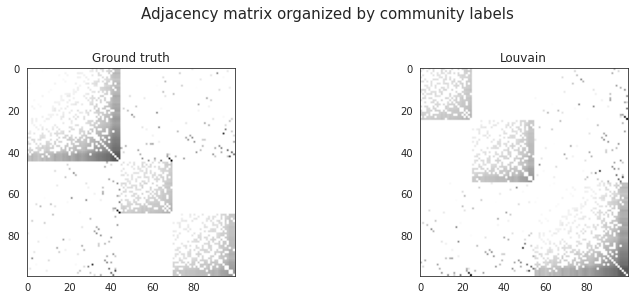

In [294]:
sns.set_style('white')
plt.figure(figsize=(12, 4))

plt.subplot(121)
idxs = np.concatenate(list(lfr['community'].values()))
plt.imshow(lfr['a'][idxs][:, idxs], cmap='Greys', interpolation='antialiased')
plt.title('Ground truth')

plt.subplot(122)
idxs = np.concatenate(list(community_pred.values()))
plt.imshow(lfr['a'][idxs][:, idxs], cmap='Greys', interpolation='antialiased')
plt.title('Louvain')

plt.suptitle('Adjacency matrix organized by community labels', fontsize=15, y=1.03)
plt.tight_layout()
plt.show()

### SVINET

In [295]:
network_name

'medium'

In [296]:
save_edgelist(lfr['g'], name=network_name, save_dir=svinet_dir)

### Run algorithm

In [297]:
!cd svinet_results/; svinet -file medium.txt -n 100 -k 3 -link-sampling -seed 42

+ Output directory: n100-k3-mmsb-seed42-linksampling
+ Writing log to n100-k3-mmsb-seed42-linksampling/infer.log
+ Reading network from medium.txt

+ Done reading network
iteration 25: processing 0 links

In [298]:
!cd svinet_results/; ls

003.txt     n1000-k6-mmsb-seed42-linksampling  no_overlap.txt
large.txt   n100-k3-mmsb-seed42-linksampling   overlap.txt
medium.txt  n5000-k9-mmsb-seed42-linksampling


In [299]:
results_dir = pjoin(svinet_dir, 'n100-k3-mmsb-seed42-linksampling')
svinet = load_svinet(results_dir=results_dir)

In [300]:
nmi, overlapping_nmi, ami, v_measure = compare_partitions(
    partition_true=lfr['partition'],
    partition_pred=svinet['partition'],
    community_true=lfr['community'],
    community_pred=svinet['community'],
)

+-----+-----------------+------------------+-----------+-----+-----------+
| NMI | overlapping-NMI | overlapping-NMI2 | Omeda-idx | AMI | v-measure |
+-----+-----------------+------------------+-----------+-----+-----------+
| 1.0 |       0.91      |       1.06       |    0.36   | 1.0 |    1.0    |
+-----+-----------------+------------------+-----------+-----+-----------+


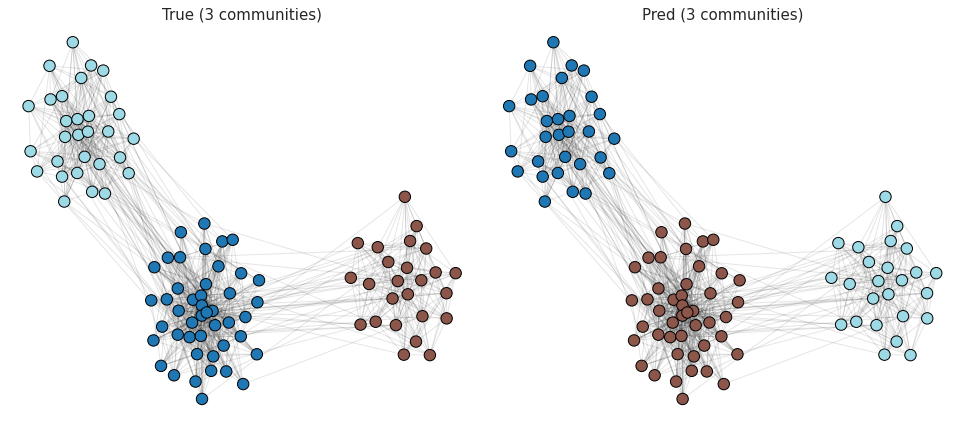

In [301]:
plot_graph(lfr['g'], partition_pred=svinet['partition'], partition_true=lfr['partition'], cmap='tab20')

### Viz memberships

In [302]:
n_nodes = lfr['g'].order()
n_comm_true = len(lfr['community'])

# true membership probabilities
pi_true = np.zeros((n_comm_true, n_nodes))
for n, mem in lfr['membership'].items():
    for comm_idx in mem:
        pi_true[comm_idx, n] = 1

pi_true /= pi_true.sum(0, keepdims=True)

# pred membership probabilities
pi_pred = np.concatenate([np.reshape(x, (1, -1)) for x in svinet['membership'].values()]).T

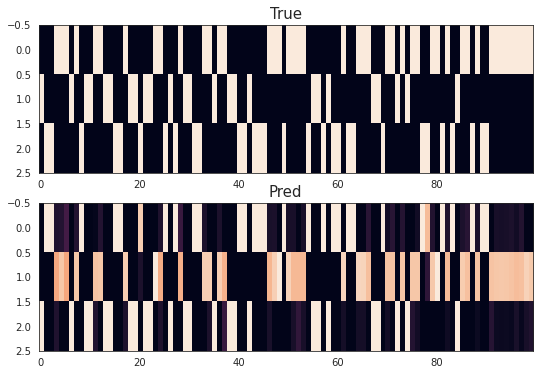

In [303]:
sns.set_style('white')
plt.figure(figsize=(24, 6))

plt.subplot(211)
plt.imshow(pi_true, aspect=10)
plt.title('True', fontsize=15)

plt.subplot(212)
plt.imshow(pi_pred, aspect=10)
plt.title('Pred', fontsize=15)

plt.show()

In [304]:
from sklearn.metrics.pairwise import cosine_similarity

In [305]:
cos_sim = cosine_similarity(pi_true, pi_pred)
print(np.round(cos_sim, decimals=1), '\n')

thres = 0.6
similarity = dict()
for true_idx in range(n_comm_true):
    sim_vec = np.where(cos_sim[true_idx] >= thres)[0]
    sim_vec = [x for _, x in sorted(zip(cos_sim[true_idx][sim_vec], sim_vec), reverse=True)]
    similarity[true_idx] = list(sim_vec)
print(similarity)

mapping = {i: sim[0] for i, sim in similarity.items()}
pi_pred = pi_pred[list(mapping.values())]

cos_sim = cosine_similarity(pi_true, pi_pred)

[[0.1 1.  0.1]
 [0.  0.  1. ]
 [1.  0.  0. ]] 

{0: [1], 1: [2], 2: [0]}


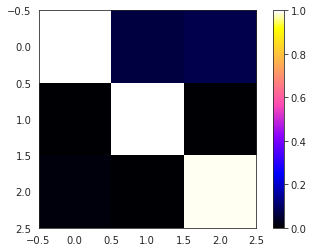

In [306]:
plt.imshow(cos_sim, vmin=0, vmax=1, cmap='gnuplot2')
plt.colorbar()

In [307]:
np.round(cos_sim, decimals=1)

array([[1. , 0.1, 0.1],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ]])

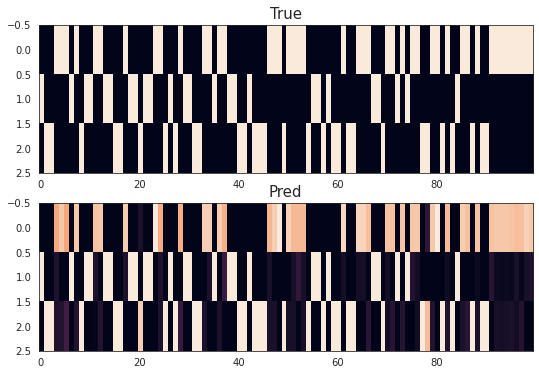

In [308]:
plt.figure(figsize=(24, 6))

plt.subplot(211)
plt.imshow(pi_true, aspect=10)
plt.title('True', fontsize=15)

plt.subplot(212)
plt.imshow(pi_pred, aspect=10)
plt.title('Pred', fontsize=15)

plt.show()

In [309]:
df = pd.DataFrame()

for i in range(len(pi_true)):
    data_dict = {
        'lbl': ['true'] * n_nodes,
        'cluster': [i] * n_nodes,
        'node': range(n_nodes),
        'p': pi_true[i],
    }
    df = pd.concat([df, pd.DataFrame.from_dict(data_dict)])

for i in range(len(pi_pred)):
    data_dict = {
        'lbl': ['pred'] * n_nodes,
        'cluster': [i] * n_nodes,
        'node': range(n_nodes),
        'p': pi_pred[i],
    }
    df = pd.concat([df, pd.DataFrame.from_dict(data_dict)])
    
df.reset_index(drop=True, inplace=True)

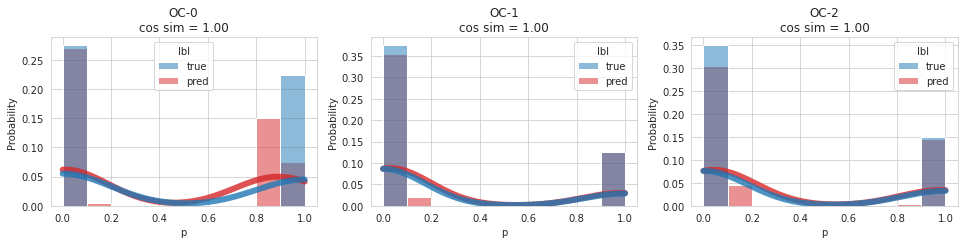

In [310]:
sns.set_style('whitegrid')
nrows, ncols = 1, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 3.5), sharex='all')
if len(axes.shape) != 2:
    axes = np.reshape(axes, (nrows, ncols))

for idx in range(n_comm_true):
    i, j = idx//ncols, idx%ncols
    selected_df = df.loc[df.cluster == idx]
    sns.histplot(
        data=selected_df,
        x='p',
        hue='lbl',
        stat='probability',
        kde=True,
        alpha=0.5,
        bins=np.linspace(0, 1, 11),
        palette={'true': 'C0', 'pred': 'C3'},
        line_kws={'lw': 6, 'alpha': 0.8},
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC-{:d}\ncos sim = {:.2f}'.format(idx, cos_sim[idx, idx]))
    
fig.tight_layout()
plt.show()

#### Entropy analysis

In [311]:
from scipy import special as sp_special

In [312]:
ent_true = sp_special.entr(pi_true).sum(0) / np.log(len(pi_true))
ent_pred = sp_special.entr(pi_pred).sum(0) / np.log(len(pi_pred))

/home/hadi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


(0.0, 1.01)

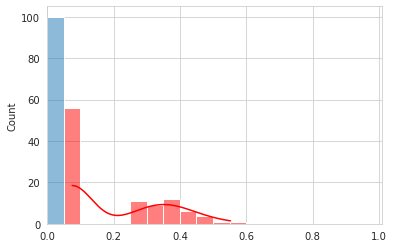

In [313]:
sns.histplot(ent_true, kde=True, bins=np.linspace(0, 1, 21))
sns.histplot(ent_pred, kde=True, bins=np.linspace(0, 1, 21), color='r')
plt.xlim(0, 1.01)

In [314]:
collections.Counter(np.round(ent_true, decimals=3))

Counter({0.0: 100})

In [315]:
(ent_pred>0.7).sum()

0

In [316]:
(ent_true<0.7).sum()

100

## Large (no overlap)

Code to generate this network:

```bash
./benchmark -N 5000 -k 500 -maxk 700 -mut 0.1 -muw 0.1 -t1 3.5 -t2 1.9 -minc 1000 -on 0 -om 0
```

In [173]:
network_name = 'large'
lfr = load_lfr(load_dir=pjoin(lfr_ws, network_name), random_state=rng)

Num true communities:	9
Num overlapping nodes:	0



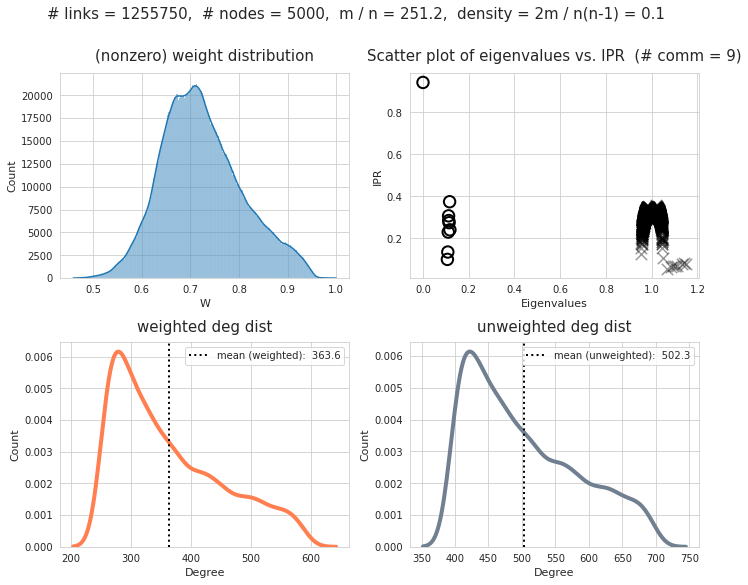

In [174]:
quick_viz(g=lfr['g'], a=lfr['a'], num_comm=len(lfr['community']))

### Louvain

The communities in this network are highly disjoint and Louvain is expected to recover ground truth.

In [175]:
partition_pred = community_louvain.best_partition(lfr['g'], resolution=1.0, random_state=RANDOM_STATE)
membership_pred = convert('partition', 'membership', partition=partition_pred, random_state=rng)
community_pred = convert('partition', 'community', partition=partition_pred, random_state=rng)

#### Plot results

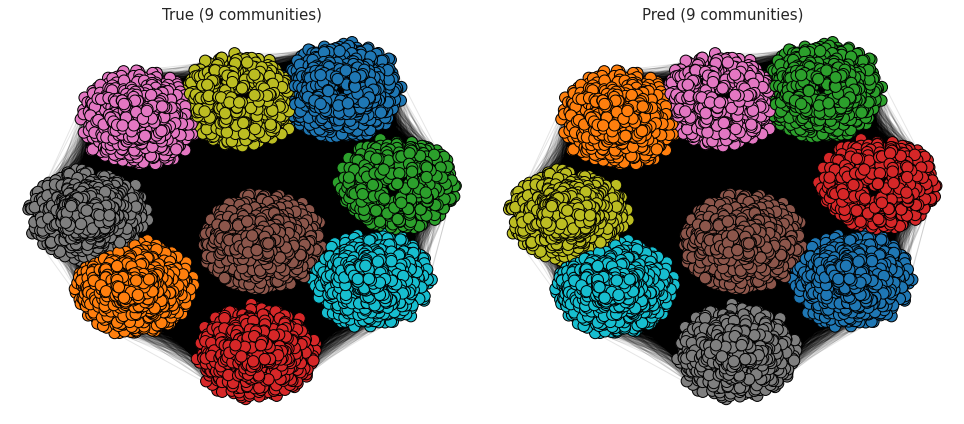

In [176]:
plot_graph(lfr['g'], partition_pred=partition_pred, partition_true=lfr['partition'], cmap='tab10')

Louvain learns the true community structure

#### Quantitative comparison 

Compute normalized_mutual_info between ground truth as returned by the benchmark code, and the partition learned by Louvain algorithm.

In [177]:
nmi, overlapping_nmi, ami, v_measure = compare_partitions(
    partition_true=lfr['partition'],
    partition_pred=partition_pred,
    community_true=lfr['community'],
    community_pred=community_pred,
)

+-----+-----------------+------------------+-----------+-----+-----------+
| NMI | overlapping-NMI | overlapping-NMI2 | Omeda-idx | AMI | v-measure |
+-----+-----------------+------------------+-----------+-----+-----------+
| 1.0 |       1.0       |       1.01       |    0.11   | 1.0 |    1.0    |
+-----+-----------------+------------------+-----------+-----+-----------+


#### Plot adjacency matrix

Here I will group nodes together using i) ground truth, and ii) Louvain community labels.  Here we also see that the gruond truth labels must be wrong.

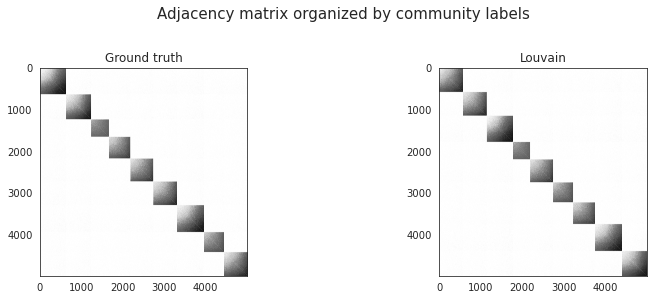

In [178]:
sns.set_style('white')
plt.figure(figsize=(12, 4))

plt.subplot(121)
idxs = np.concatenate(list(lfr['community'].values()))
plt.imshow(lfr['a'][idxs][:, idxs], cmap='Greys', interpolation='antialiased')
plt.title('Ground truth')

plt.subplot(122)
idxs = np.concatenate(list(community_pred.values()))
plt.imshow(lfr['a'][idxs][:, idxs], cmap='Greys', interpolation='antialiased')
plt.title('Louvain')

plt.suptitle('Adjacency matrix organized by community labels', fontsize=15, y=1.03)
plt.tight_layout()
plt.show()

### SVINET

In [179]:
network_name

'large'

In [180]:
save_edgelist(lfr['g'], name=network_name, save_dir=svinet_dir)

### Run algorithm

In [181]:
!cd svinet_results/; svinet -file large.txt -n 5000 -k 9 -link-sampling -seed 42

+ Output directory: n5000-k9-mmsb-seed42-linksampling
+ Writing log to n5000-k9-mmsb-seed42-linksampling/infer.log
+ Reading network from large.txt
+ 1250000 entries
+ Done reading network
iteration 22: processing 1249000 links

In [182]:
!cd svinet_results/; ls

003.txt     n1000-k6-mmsb-seed42-linksampling  no_overlap.txt
large.txt   n100-k3-mmsb-seed42-linksampling   overlap.txt
medium.txt  n5000-k9-mmsb-seed42-linksampling


In [183]:
results_dir = pjoin(svinet_dir, 'n5000-k9-mmsb-seed42-linksampling')
svinet = load_svinet(results_dir=results_dir)

In [184]:
nmi, overlapping_nmi, ami, v_measure = compare_partitions(
    partition_true=lfr['partition'],
    partition_pred=svinet['partition'],
    community_true=lfr['community'],
    community_pred=svinet['community'],
)

+-----+-----------------+------------------+-----------+-----+-----------+
| NMI | overlapping-NMI | overlapping-NMI2 | Omeda-idx | AMI | v-measure |
+-----+-----------------+------------------+-----------+-----+-----------+
| 1.0 |       0.12      |       0.61       |    0.11   | 1.0 |    1.0    |
+-----+-----------------+------------------+-----------+-----+-----------+


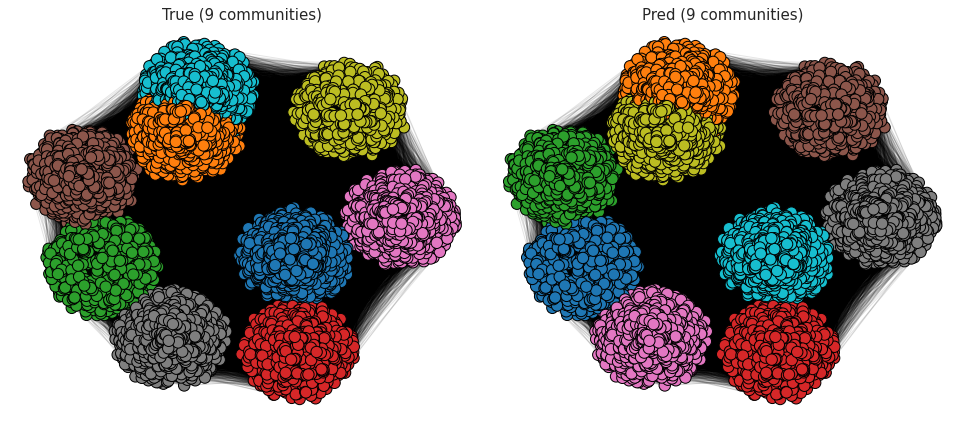

In [185]:
plot_graph(lfr['g'], partition_pred=svinet['partition'], partition_true=lfr['partition'], cmap='tab10')

### Viz memberships

In [190]:
n_nodes = lfr['g'].order()
n_comm_true = len(lfr['community'])

# true membership probabilities
pi_true = np.zeros((n_comm_true, n_nodes))
for n, mem in lfr['membership'].items():
    for comm_idx in mem:
        pi_true[comm_idx, n] = 1

pi_true /= pi_true.sum(0, keepdims=True)

# pred membership probabilities
pi_pred = np.concatenate([np.reshape(x, (1, -1)) for x in svinet['membership'].values()]).T

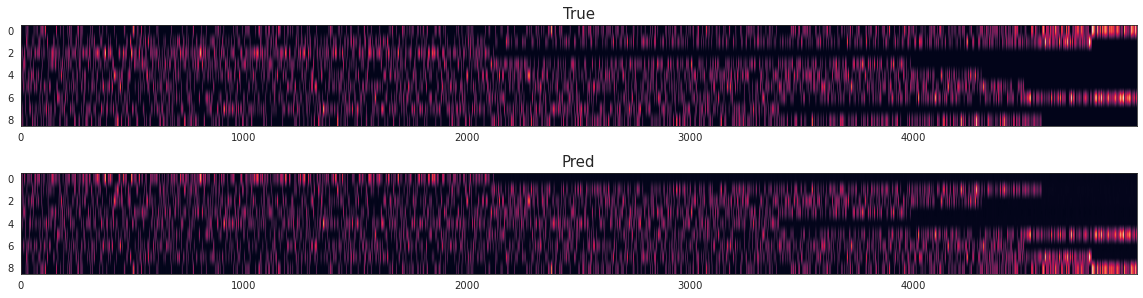

In [194]:
sns.set_style('white')
plt.figure(figsize=(20, 5))

plt.subplot(211)
plt.imshow(pi_true, aspect=50)
plt.title('True', fontsize=15)

plt.subplot(212)
plt.imshow(pi_pred, aspect=50)
plt.title('Pred', fontsize=15)

plt.show()

In [195]:
from sklearn.metrics.pairwise import cosine_similarity

In [196]:
cos_sim = cosine_similarity(pi_true, pi_pred)
print(np.round(cos_sim, decimals=1), '\n')

thres = 0.6
similarity = dict()
for true_idx in range(n_comm_true):
    sim_vec = np.where(cos_sim[true_idx] >= thres)[0]
    sim_vec = [x for _, x in sorted(zip(cos_sim[true_idx][sim_vec], sim_vec), reverse=True)]
    similarity[true_idx] = list(sim_vec)
print(similarity)

mapping = {i: sim[0] for i, sim in similarity.items()}
pi_pred = pi_pred[list(mapping.values())]

cos_sim = cosine_similarity(pi_true, pi_pred)

[[0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]] 

{0: [8], 1: [7], 2: [0], 3: [3], 4: [2], 5: [6], 6: [5], 7: [4], 8: [1]}


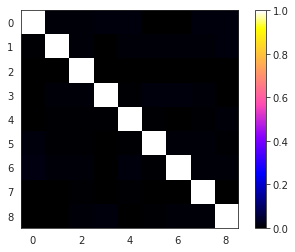

In [197]:
plt.imshow(cos_sim, vmin=0, vmax=1, cmap='gnuplot2')
plt.colorbar()

In [198]:
np.round(cos_sim, decimals=1)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

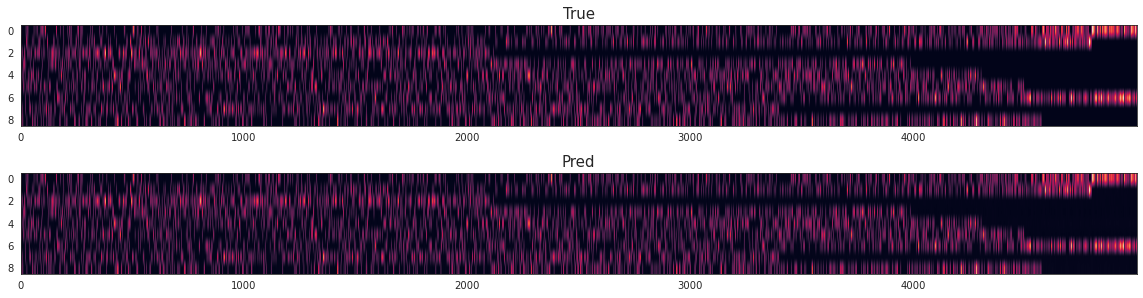

In [199]:
sns.set_style('white')
plt.figure(figsize=(20, 5))

plt.subplot(211)
plt.imshow(pi_true, aspect=50)
plt.title('True', fontsize=15)

plt.subplot(212)
plt.imshow(pi_pred, aspect=50)
plt.title('Pred', fontsize=15)

plt.show()

In [200]:
df = pd.DataFrame()

for i in range(len(pi_true)):
    data_dict = {
        'lbl': ['true'] * n_nodes,
        'cluster': [i] * n_nodes,
        'node': range(n_nodes),
        'p': pi_true[i],
    }
    df = pd.concat([df, pd.DataFrame.from_dict(data_dict)])

for i in range(len(pi_pred)):
    data_dict = {
        'lbl': ['pred'] * n_nodes,
        'cluster': [i] * n_nodes,
        'node': range(n_nodes),
        'p': pi_pred[i],
    }
    df = pd.concat([df, pd.DataFrame.from_dict(data_dict)])
    
df.reset_index(drop=True, inplace=True)

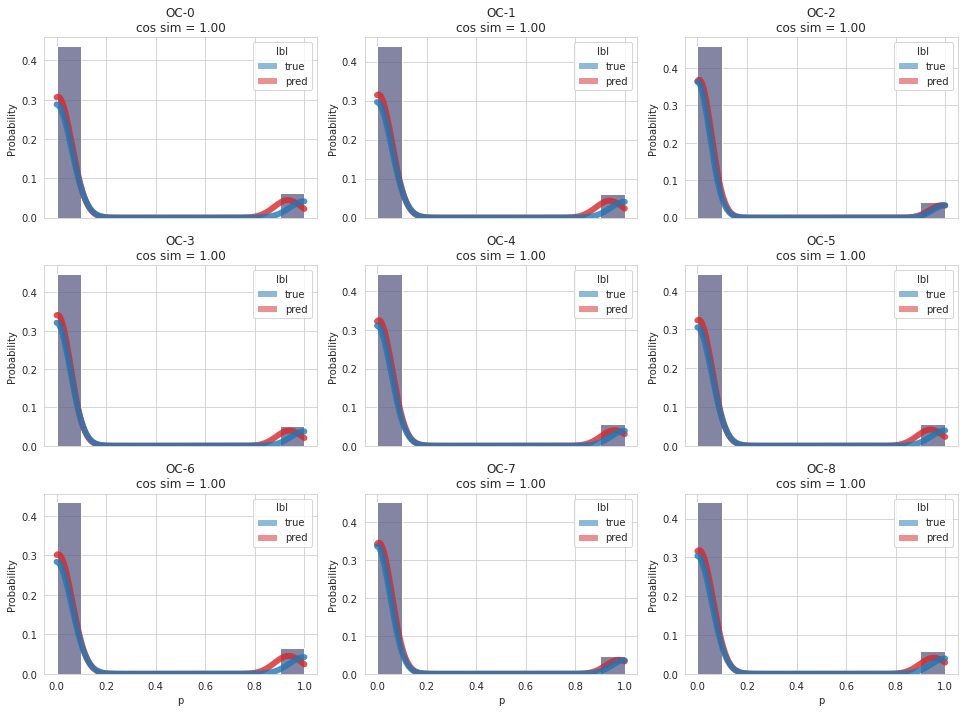

In [203]:
sns.set_style('whitegrid')
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 10), sharex='all')
if len(axes.shape) != 2:
    axes = np.reshape(axes, (nrows, ncols))

for idx in range(n_comm_true):
    i, j = idx//ncols, idx%ncols
    selected_df = df.loc[df.cluster == idx]
    sns.histplot(
        data=selected_df,
        x='p',
        hue='lbl',
        stat='probability',
        kde=True,
        alpha=0.5,
        bins=np.linspace(0, 1, 11),
        palette={'true': 'C0', 'pred': 'C3'},
        line_kws={'lw': 6, 'alpha': 0.8},
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC-{:d}\ncos sim = {:.2f}'.format(idx, cos_sim[idx, idx]))
    
fig.tight_layout()
plt.show()

## An overlapping network

The bug persists for the overlapping case. Here I will load an overlapping network to show this.  Code to generate the network used below:

```bash
./benchmark -N 1000 -k 200 -maxk 500 -mut 0.1 -muw 0.1 -t1 3 -t2 1.7 -minc 400 -on 100 -om 5

```

In [317]:
network_name = 'overlap'
lfr = load_lfr(load_dir=pjoin(lfr_ws, network_name), random_state=rng)

Num true communities:	6
Num overlapping nodes:	100



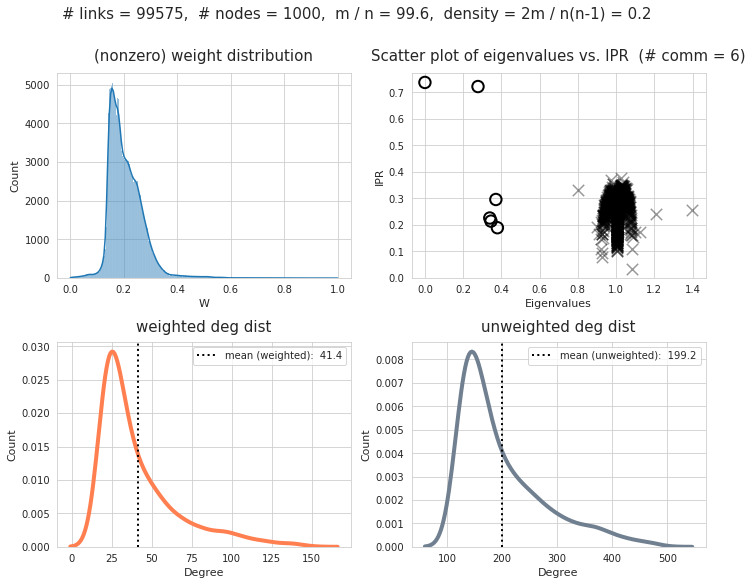

In [318]:
quick_viz(g=lfr['g'], a=lfr['a'], num_comm=len(lfr['community']))

### Louvain

The communities in this network are highly disjoint and Louvain is expected to recover ground truth.

In [319]:
partition_pred = community_louvain.best_partition(lfr['g'], resolution=1.0, random_state=RANDOM_STATE)
membership_pred = convert('partition', 'membership', partition=partition_pred, random_state=rng)
community_pred = convert('partition', 'community', partition=partition_pred, random_state=rng)

#### Plot results

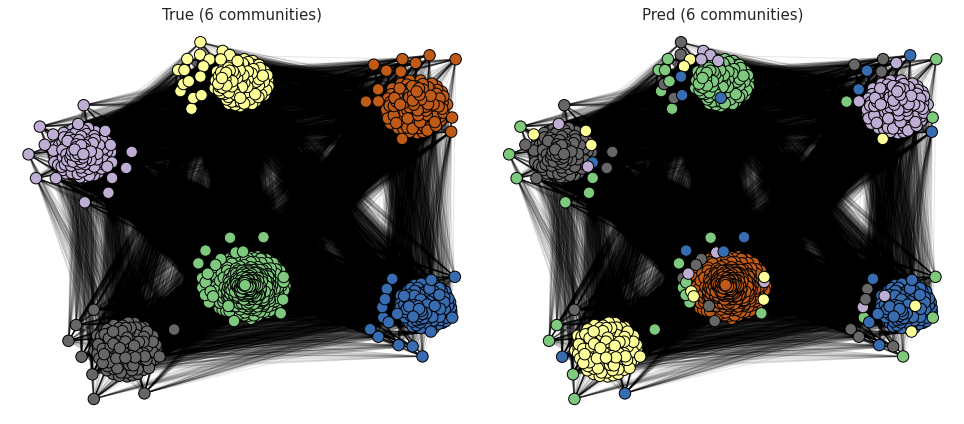

In [320]:
plot_graph(lfr['g'], partition_pred=partition_pred, partition_true=lfr['partition'])

Louvain learns the true community structure

#### Quantitative comparison 

Compute normalized_mutual_info between ground truth as returned by the benchmark code, and the partition learned by Louvain algorithm.

In [321]:
nmi, overlapping_nmi, ami, v_measure = compare_partitions(
    partition_true=lfr['partition'],
    partition_pred=partition_pred,
    community_true=lfr['community'],
    community_pred=community_pred,
)

+------+-----------------+------------------+-----------+------+-----------+
| NMI  | overlapping-NMI | overlapping-NMI2 | Omeda-idx | AMI  | v-measure |
+------+-----------------+------------------+-----------+------+-----------+
| 0.78 |       0.56      |       0.85       |    0.21   | 0.78 |    0.78   |
+------+-----------------+------------------+-----------+------+-----------+


#### Plot adjacency matrix

Here I will group nodes together using i) ground truth, and ii) Louvain community labels.  Here we also see that the gruond truth labels must be wrong.

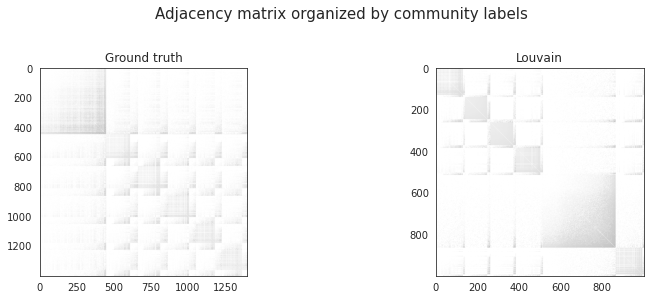

In [322]:
sns.set_style('white')
plt.figure(figsize=(12, 4))

plt.subplot(121)
idxs = np.concatenate(list(lfr['community'].values()))
plt.imshow(lfr['a'][idxs][:, idxs], cmap='Greys', interpolation='antialiased')
plt.title('Ground truth')

plt.subplot(122)
idxs = np.concatenate(list(community_pred.values()))
plt.imshow(lfr['a'][idxs][:, idxs], cmap='Greys', interpolation='antialiased')
plt.title('Louvain')

plt.suptitle('Adjacency matrix organized by community labels', fontsize=15, y=1.03)
plt.tight_layout()
plt.show()

### SVINET

In [323]:
network_name

'overlap'

In [324]:
save_edgelist(lfr['g'], name=network_name, save_dir=svinet_dir)

### Run algorithm

In [325]:
!cd svinet_results/; svinet -file overlap.txt -n 1000 -k 6 -link-sampling -seed 42

+ Output directory: n1000-k6-mmsb-seed42-linksampling
+ Writing log to n1000-k6-mmsb-seed42-linksampling/infer.log
+ Reading network from overlap.txt
+ 90000 entries
+ Done reading network
iteration 44: processing 99000 links

In [326]:
!cd svinet_results/; ls

003.txt     n1000-k6-mmsb-seed42-linksampling  no_overlap.txt
large.txt   n100-k3-mmsb-seed42-linksampling   overlap.txt
medium.txt  n5000-k9-mmsb-seed42-linksampling


In [327]:
results_dir = pjoin(svinet_dir, 'n1000-k6-mmsb-seed42-linksampling')
svinet = load_svinet(results_dir=results_dir)

In [328]:
nmi, overlapping_nmi, ami, v_measure = compare_partitions(
    partition_true=lfr['partition'],
    partition_pred=svinet['partition'],
    community_true=lfr['community'],
    community_pred=svinet['community'],
)

+------+-----------------+------------------+-----------+------+-----------+
| NMI  | overlapping-NMI | overlapping-NMI2 | Omeda-idx | AMI  | v-measure |
+------+-----------------+------------------+-----------+------+-----------+
| 0.74 |       0.43      |       0.69       |    0.31   | 0.74 |    0.74   |
+------+-----------------+------------------+-----------+------+-----------+


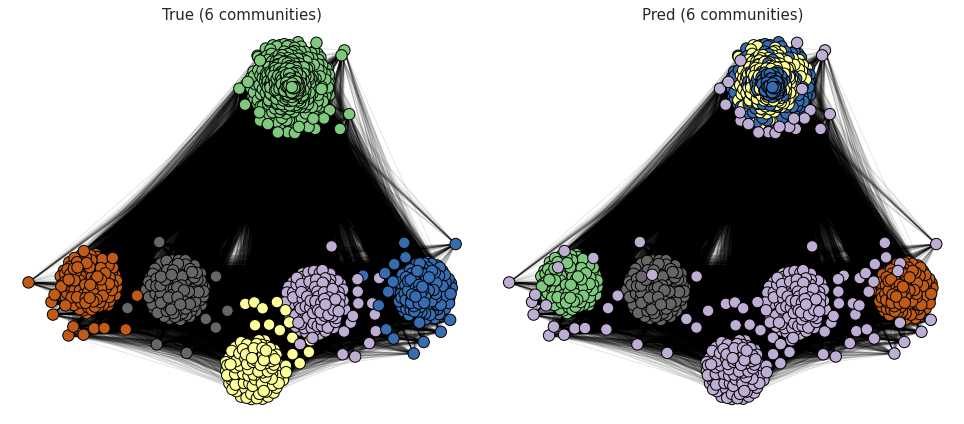

In [329]:
plot_graph(lfr['g'], partition_pred=svinet['partition'], partition_true=lfr['partition'])

### Viz memberships

In [330]:
n_nodes = lfr['g'].order()
n_comm_true = len(lfr['community'])

# true membership probabilities
pi_true = np.zeros((n_comm_true, n_nodes))
for n, mem in lfr['membership'].items():
    for comm_idx in mem:
        pi_true[comm_idx, n] = 1

pi_true /= pi_true.sum(0, keepdims=True)

# pred membership probabilities
pi_pred = np.concatenate([np.reshape(x, (1, -1)) for x in svinet['membership'].values()]).T

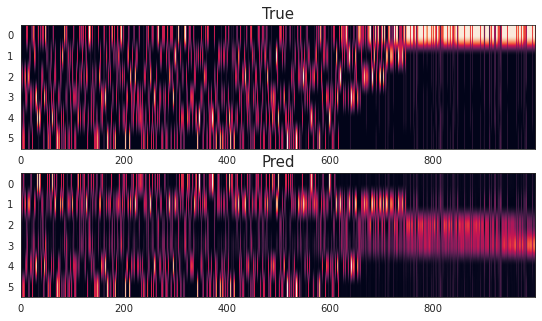

In [331]:
sns.set_style('white')
plt.figure(figsize=(20, 5))

plt.subplot(211)
plt.imshow(pi_true, aspect=40)
plt.title('True', fontsize=15)

plt.subplot(212)
plt.imshow(pi_pred, aspect=40)
plt.title('Pred', fontsize=15)

plt.show()

In [332]:
from sklearn.metrics.pairwise import cosine_similarity

In [333]:
cos_sim = cosine_similarity(pi_true, pi_pred)
print(np.round(cos_sim, decimals=1), '\n')

thres = 0.6
similarity = dict()
for true_idx in range(n_comm_true):
    sim_vec = np.where(cos_sim[true_idx] >= thres)[0]
    sim_vec = [x for _, x in sorted(zip(cos_sim[true_idx][sim_vec], sim_vec), reverse=True)]
    similarity[true_idx] = list(sim_vec)
print(similarity)

mapping = {i: sim[0] for i, sim in similarity.items()}
pi_pred = pi_pred[list(mapping.values())]

cos_sim = cosine_similarity(pi_true, pi_pred)

[[0.  0.  1.  1.  0.  0. ]
 [0.  0.7 0.  0.2 0.  0. ]
 [0.  0.7 0.  0.1 0.  0. ]
 [0.  0.  0.  0.  1.  0. ]
 [1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1. ]] 

{0: [2, 3], 1: [1], 2: [1], 3: [4], 4: [0], 5: [5]}


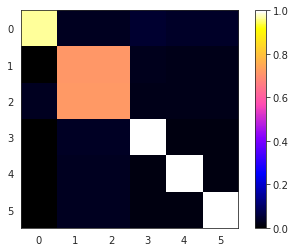

In [334]:
plt.imshow(cos_sim, vmin=0, vmax=1, cmap='gnuplot2')
plt.colorbar()

In [335]:
np.round(cos_sim, decimals=1)

array([[1. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.7, 0.7, 0. , 0. , 0. ],
       [0. , 0.7, 0.7, 0. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. ]])

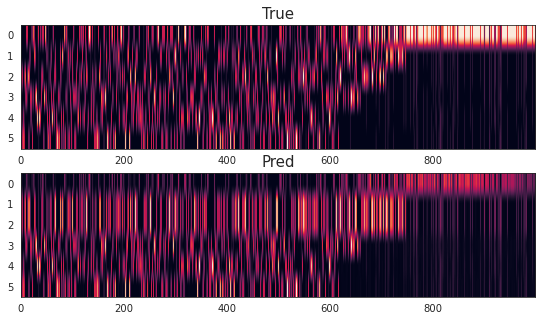

In [336]:
sns.set_style('white')
plt.figure(figsize=(20, 5))

plt.subplot(211)
plt.imshow(pi_true, aspect=40)
plt.title('True', fontsize=15)

plt.subplot(212)
plt.imshow(pi_pred, aspect=40)
plt.title('Pred', fontsize=15)

plt.show()

In [337]:
df = pd.DataFrame()

for i in range(len(pi_true)):
    data_dict = {
        'lbl': ['true'] * n_nodes,
        'cluster': [i] * n_nodes,
        'node': range(n_nodes),
        'p': pi_true[i],
    }
    df = pd.concat([df, pd.DataFrame.from_dict(data_dict)])

for i in range(len(pi_pred)):
    data_dict = {
        'lbl': ['pred'] * n_nodes,
        'cluster': [i] * n_nodes,
        'node': range(n_nodes),
        'p': pi_pred[i],
    }
    df = pd.concat([df, pd.DataFrame.from_dict(data_dict)])
    
df.reset_index(drop=True, inplace=True)

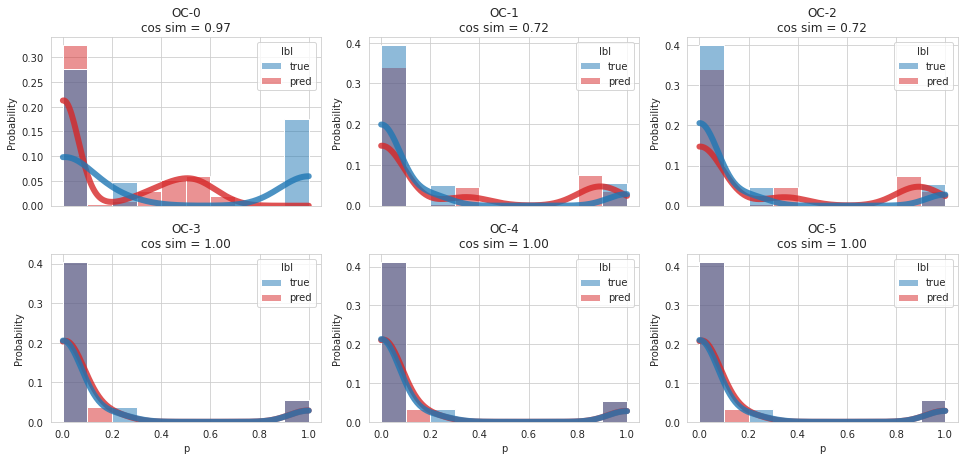

In [338]:
sns.set_style('whitegrid')
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 6.5), sharex='all')
if len(axes.shape) != 2:
    axes = np.reshape(axes, (nrows, ncols))

for idx in range(n_comm_true):
    i, j = idx//ncols, idx%ncols
    selected_df = df.loc[df.cluster == idx]
    sns.histplot(
        data=selected_df,
        x='p',
        hue='lbl',
        stat='probability',
        kde=True,
        alpha=0.5,
        bins=np.linspace(0, 1, 11),
        palette={'true': 'C0', 'pred': 'C3'},
        line_kws={'lw': 6, 'alpha': 0.8},
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC-{:d}\ncos sim = {:.2f}'.format(idx, cos_sim[idx, idx]))
    
fig.tight_layout()
plt.show()

#### Entropy analysis

In [339]:
from scipy import special as sp_special

In [340]:
ent_true = sp_special.entr(pi_true).sum(0) / np.log(len(pi_true))
ent_pred = sp_special.entr(pi_pred).sum(0) / np.log(len(pi_pred))

(0.0, 1.01)

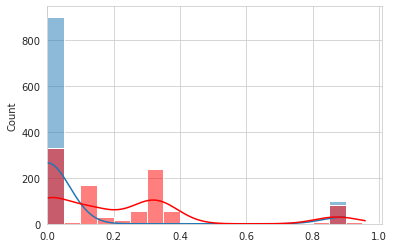

In [341]:
sns.histplot(ent_true, kde=True, bins=np.linspace(0, 1, 21))
sns.histplot(ent_pred, kde=True, bins=np.linspace(0, 1, 21), color='r')
plt.xlim(0, 1.01)

In [342]:
collections.Counter(np.round(ent_true, decimals=3))

Counter({0.0: 900, 0.898: 100})

In [343]:
(ent_pred>0.7).sum()

100

In [344]:
(ent_true<0.7).sum()

900

## Name: 003 (lots of overlap)

```bash
./benchmark -N 1000 -k 100 -maxk 200 -mut 0.1 -muw 0.1 -t1 3 -t2 1.7 -minc 400 -on 500 -om 10
```

In [345]:
network_name = '003'
lfr = load_lfr(load_dir=pjoin(lfr_ws, network_name), random_state=rng)

Num true communities:	46
Num overlapping nodes:	500



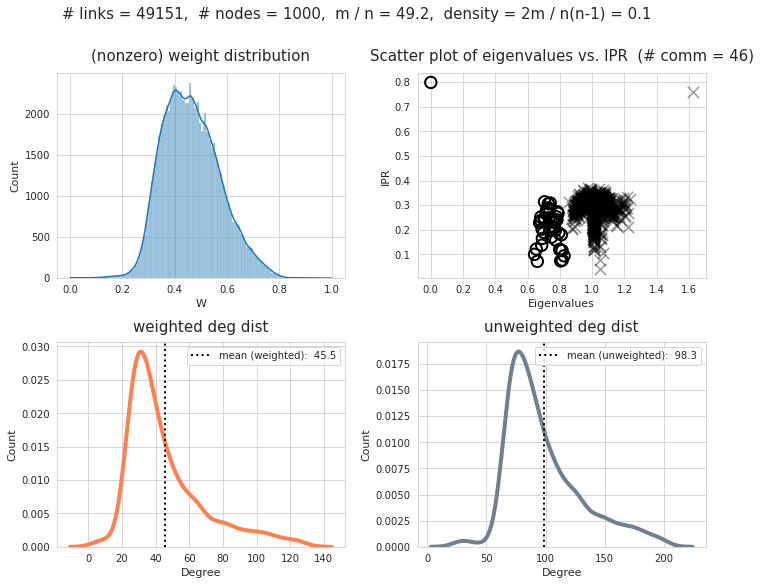

In [346]:
quick_viz(g=lfr['g'], a=lfr['a'], num_comm=len(lfr['community']))

### Louvain

The communities in this network are highly disjoint and Louvain is expected to recover ground truth.

In [347]:
partition_pred = community_louvain.best_partition(lfr['g'], resolution=1.0, random_state=RANDOM_STATE)
membership_pred = convert('partition', 'membership', partition=partition_pred, random_state=rng)
community_pred = convert('partition', 'community', partition=partition_pred, random_state=rng)

#### Plot results

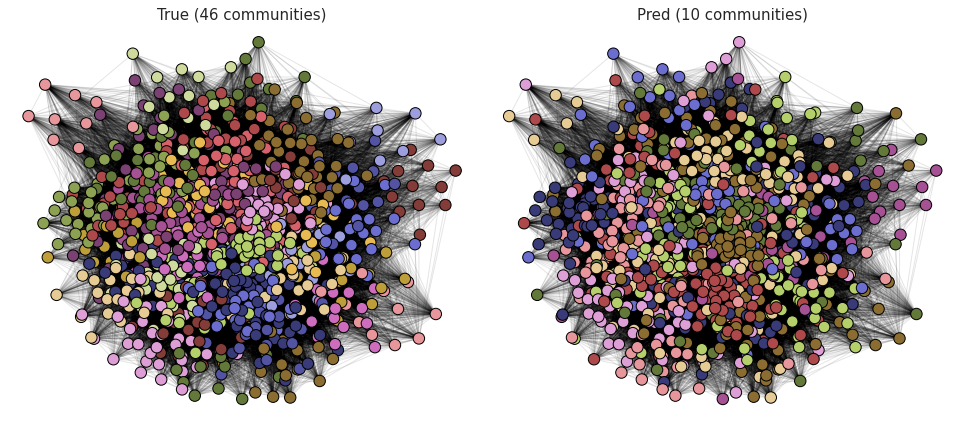

In [348]:
plot_graph(lfr['g'], partition_pred=partition_pred, partition_true=lfr['partition'], cmap='tab20b')

Louvain learns the true community structure

#### Quantitative comparison 

Compute normalized_mutual_info between ground truth as returned by the benchmark code, and the partition learned by Louvain algorithm.

In [349]:
nmi, overlapping_nmi, ami, v_measure = compare_partitions(
    partition_true=lfr['partition'],
    partition_pred=partition_pred,
    community_true=lfr['community'],
    community_pred=community_pred,
)

+------+-----------------+------------------+-----------+------+-----------+
| NMI  | overlapping-NMI | overlapping-NMI2 | Omeda-idx | AMI  | v-measure |
+------+-----------------+------------------+-----------+------+-----------+
| 0.33 |       0.0       |      -0.75       |    0.06   | 0.27 |    0.33   |
+------+-----------------+------------------+-----------+------+-----------+


#### Plot adjacency matrix

Here I will group nodes together using i) ground truth, and ii) Louvain community labels.  Here we also see that the gruond truth labels must be wrong.

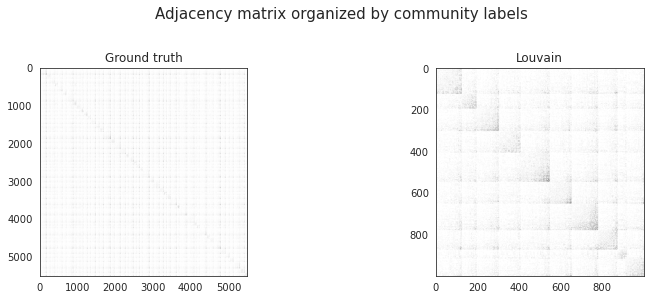

In [350]:
sns.set_style('white')
plt.figure(figsize=(12, 4))

plt.subplot(121)
idxs = np.concatenate(list(lfr['community'].values()))
plt.imshow(lfr['a'][idxs][:, idxs], cmap='Greys', interpolation='antialiased')
plt.title('Ground truth')

plt.subplot(122)
idxs = np.concatenate(list(community_pred.values()))
plt.imshow(lfr['a'][idxs][:, idxs], cmap='Greys', interpolation='antialiased')
plt.title('Louvain')

plt.suptitle('Adjacency matrix organized by community labels', fontsize=15, y=1.03)
plt.tight_layout()
plt.show()

### SVINET

In [351]:
network_name

'003'

In [352]:
save_edgelist(lfr['g'], name=network_name, save_dir=svinet_dir)

### Run algorithm

In [353]:
!cd svinet_results/; svinet -file overlap.txt -n 1000 -k 10 -link-sampling -seed 42

+ Output directory: n1000-k10-mmsb-seed42-linksampling
+ Writing log to n1000-k10-mmsb-seed42-linksampling/infer.log
+ Reading network from overlap.txt
+ 90000 entries
+ Done reading network
iteration 38: processing 99000 links

In [354]:
!cd svinet_results/; ls

003.txt				    n100-k3-mmsb-seed42-linksampling
large.txt			    n5000-k9-mmsb-seed42-linksampling
medium.txt			    no_overlap.txt
n1000-k10-mmsb-seed42-linksampling  overlap.txt
n1000-k6-mmsb-seed42-linksampling


In [355]:
results_dir = pjoin(svinet_dir, 'n1000-k10-mmsb-seed42-linksampling')
svinet = load_svinet(results_dir=results_dir)

In [356]:
nmi, overlapping_nmi, ami, v_measure = compare_partitions(
    partition_true=lfr['partition'],
    partition_pred=svinet['partition'],
    community_true=lfr['community'],
    community_pred=svinet['community'],
)

+------+-----------------+------------------+-----------+-----+-----------+
| NMI  | overlapping-NMI | overlapping-NMI2 | Omeda-idx | AMI | v-measure |
+------+-----------------+------------------+-----------+-----+-----------+
| 0.08 |       0.0       |      -1.37       |    0.3    | 0.0 |    0.08   |
+------+-----------------+------------------+-----------+-----+-----------+


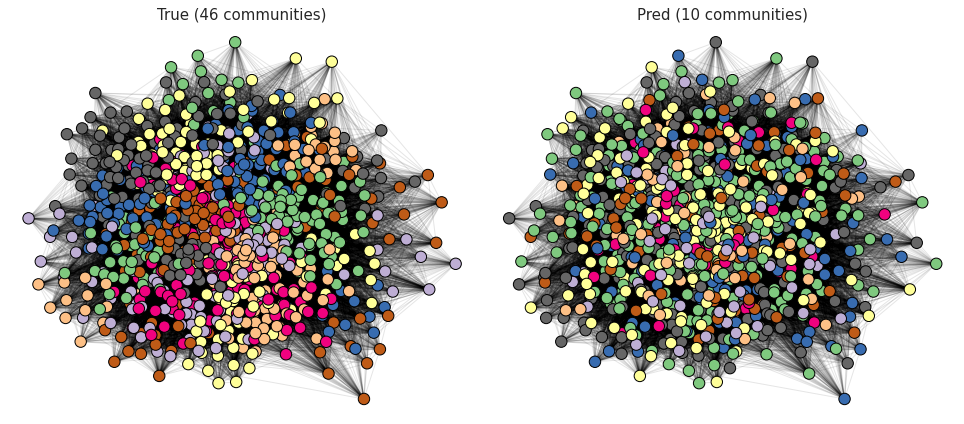

In [357]:
plot_graph(lfr['g'], partition_pred=svinet['partition'], partition_true=lfr['partition'])

### Viz memberships

In [427]:
n_nodes = lfr['g'].order()
n_comm_true = len(lfr['community'])

# true membership probabilities
pi_true = np.zeros((n_comm_true, n_nodes))
for n, mem in lfr['membership'].items():
    for comm_idx in mem:
        pi_true[comm_idx, n] = 1

pi_true /= pi_true.sum(0, keepdims=True)

# pred membership probabilities
pi_pred = np.concatenate([np.reshape(x, (1, -1)) for x in svinet['membership'].values()]).T

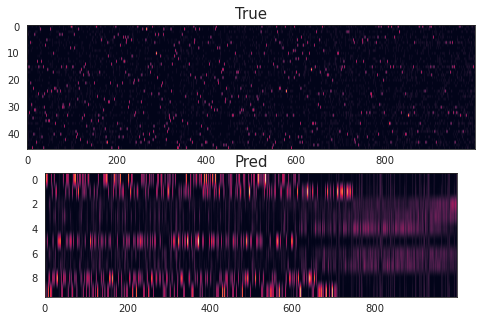

In [428]:
sns.set_style('white')
plt.figure(figsize=(20, 5))

plt.subplot(211)
plt.imshow(pi_true, aspect=6)
plt.title('True', fontsize=15)

plt.subplot(212)
plt.imshow(pi_pred, aspect=30)
plt.title('Pred', fontsize=15)

plt.show()

In [429]:
from sklearn.metrics.pairwise import cosine_similarity

In [430]:
cos_sim = cosine_similarity(pi_true, pi_pred)
print(np.round(cos_sim, decimals=1), '\n')

thres = 0.05
similarity = dict()
for true_idx in range(n_comm_true):
    sim_vec = np.where(cos_sim[true_idx] >= thres)[0]
    sim_vec = [x for _, x in sorted(zip(cos_sim[true_idx][sim_vec], sim_vec), reverse=True)]
    similarity[true_idx] = list(sim_vec)
print(similarity)

mapping = {i: sim[0] for i, sim in similarity.items()}
pi_pred = pi_pred[list(mapping.values())]

cos_sim = cosine_similarity(pi_true, pi_pred)

[[0.1 0.1 0.2 0.1 0.1 0.1 0.2 0.2 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.2 0.1 0.2 0.  0.1 0.2 0.1 0.1]
 [0.1 0.1 0.1 0.  0.  0.1 0.1 0.1 0.1 0.1]
 [0.  0.1 0.2 0.2 0.2 0.1 0.2 0.2 0.  0. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.  0.1 0.2 0.1 0.2 0.1 0.2 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.  0.1 0.1 0.  0. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1]
 [0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.  0.1 0.1 0.1 0. ]
 [0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.2 0.  0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0. ]
 [0.1 0.1 0.2 0.2 0.2 0.1 0.2 0.2 0.1 0.1]
 [0.  0.  0.1 0.2 0.1 0.  0.1 0.1 0.1 0.1]
 [0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.2 0.1 0.1]
 [0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.1 0.  0. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0. ]
 [0.1 0.1 0.1 0.2 0.1 0.1 0.2 0.1 0.1 0.1]
 [0.1 0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1]
 [0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.  0.  0

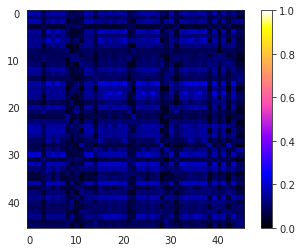

In [431]:
plt.imshow(cos_sim, vmin=0, vmax=1, cmap='gnuplot2')
plt.colorbar()

In [432]:
np.round(cos_sim, decimals=1)

array([[0.2, 0.2, 0.2, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.2, 0.2, 0.2, ..., 0.1, 0.1, 0.1],
       ...,
       [0.1, 0.1, 0.1, ..., 0.2, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]])

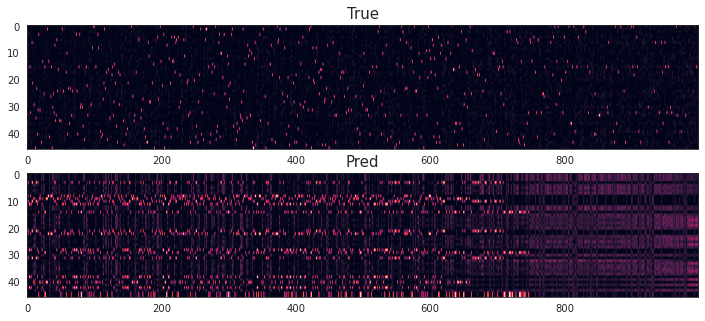

In [433]:
sns.set_style('white')
plt.figure(figsize=(20, 5))

plt.subplot(211)
plt.imshow(pi_true, aspect=4)
plt.title('True', fontsize=15)

plt.subplot(212)
plt.imshow(pi_pred, aspect=4)
plt.title('Pred', fontsize=15)

plt.show()

In [434]:
df = pd.DataFrame()

for i in range(len(pi_true)):
    data_dict = {
        'lbl': ['true'] * n_nodes,
        'cluster': [i] * n_nodes,
        'node': range(n_nodes),
        'p': pi_true[i],
    }
    df = pd.concat([df, pd.DataFrame.from_dict(data_dict)])

for i in range(len(pi_pred)):
    data_dict = {
        'lbl': ['pred'] * n_nodes,
        'cluster': [i] * n_nodes,
        'node': range(n_nodes),
        'p': pi_pred[i],
    }
    df = pd.concat([df, pd.DataFrame.from_dict(data_dict)])
    
df.reset_index(drop=True, inplace=True)

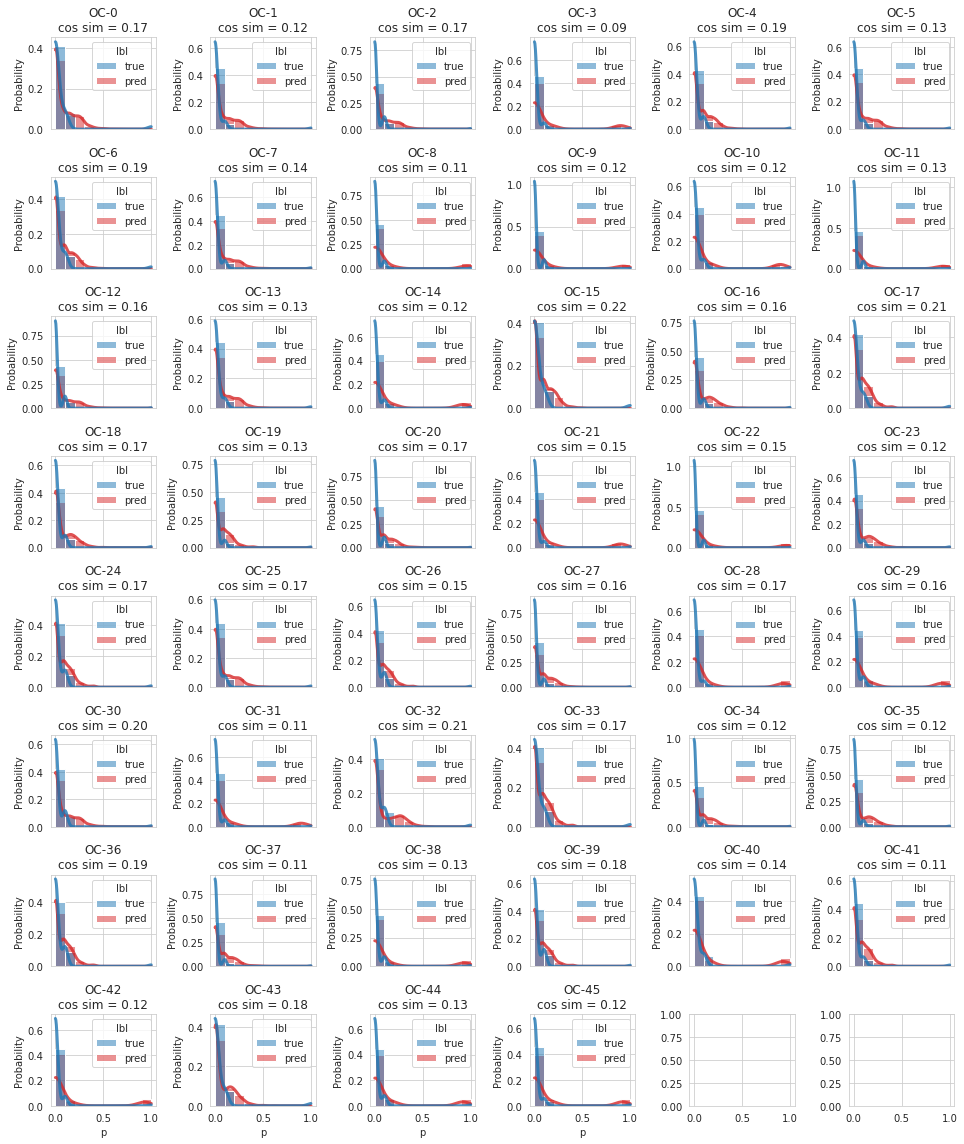

In [435]:
sns.set_style('whitegrid')
nrows, ncols = 8, 6
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 16), sharex='all')
if len(axes.shape) != 2:
    axes = np.reshape(axes, (nrows, ncols))

for idx in range(n_comm_true):
    i, j = idx//ncols, idx%ncols
    selected_df = df.loc[df.cluster == idx]
    sns.histplot(
        data=selected_df,
        x='p',
        hue='lbl',
        stat='probability',
        kde=True,
        alpha=0.5,
        bins=np.linspace(0, 1, 11),
        palette={'true': 'C0', 'pred': 'C3'},
        line_kws={'lw': 3, 'alpha': 0.8},
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC-{:d}\ncos sim = {:.2f}'.format(idx, cos_sim[idx, idx]))
    
fig.tight_layout()
plt.show()

#### Entropy analysis

In [436]:
from scipy import special as sp_special

In [438]:
pi_pred = np.concatenate([np.reshape(x, (1, -1)) for x in svinet['membership'].values()]).T

In [439]:
ent_true = sp_special.entr(pi_true).sum(0) / np.log(len(pi_true))
ent_pred = sp_special.entr(pi_pred).sum(0) / np.log(len(pi_pred))

(0.0, 1.01)

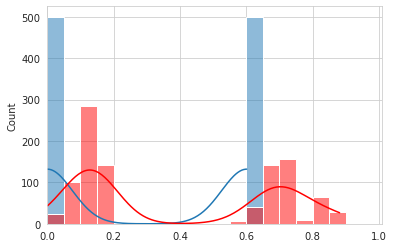

In [440]:
sns.histplot(ent_true, kde=True, bins=np.linspace(0, 1, 21))
sns.histplot(ent_pred, kde=True, bins=np.linspace(0, 1, 21), color='r')
plt.xlim(0, 1.01)

In [441]:
collections.Counter(np.round(ent_true, decimals=3))

Counter({0.0: 500, 0.601: 500})

In [442]:
(ent_pred>0.4).sum()

450

In [443]:
(ent_pred<0.4).sum()

550